# rembg
Обрезка полей с помощью библиотеки rembg, предназначенной для удаления фона с изображений  
https://github.com/danielgatis/rembg  
2.0.24 - рабочая версия на 10.12.2022

In [ ]:
! pip install rembg==2.0.24

Импортируем функцию удаления фона

In [76]:
from rembg import remove as rembg_remove

## Пример

In [2]:
import requests
from PIL import Image

Функция для скачивания изображения из хранилища

In [3]:
def download(url, filename):
    photo_content = requests.get(url).content
    with open(filename, 'wb') as photo_file:
        photo_file.write(photo_content)

Функция обрезки с помощью rembg

In [118]:
def crop_rembg(input_path, output_path):
    with open(input_path, 'rb') as i:
        with open(output_path, 'wb') as o:
            input = i.read()
            output = rembg_remove(input)
            o.write(output)

Пример работы

In [121]:
download('https://storage.yandexcloud.net/postcards-open-sources/ayby%20(80).jpg', 'example-orig.jpg')
crop_rembg('example-orig.jpg', 'example-rembg.jpg')

Исходный скан

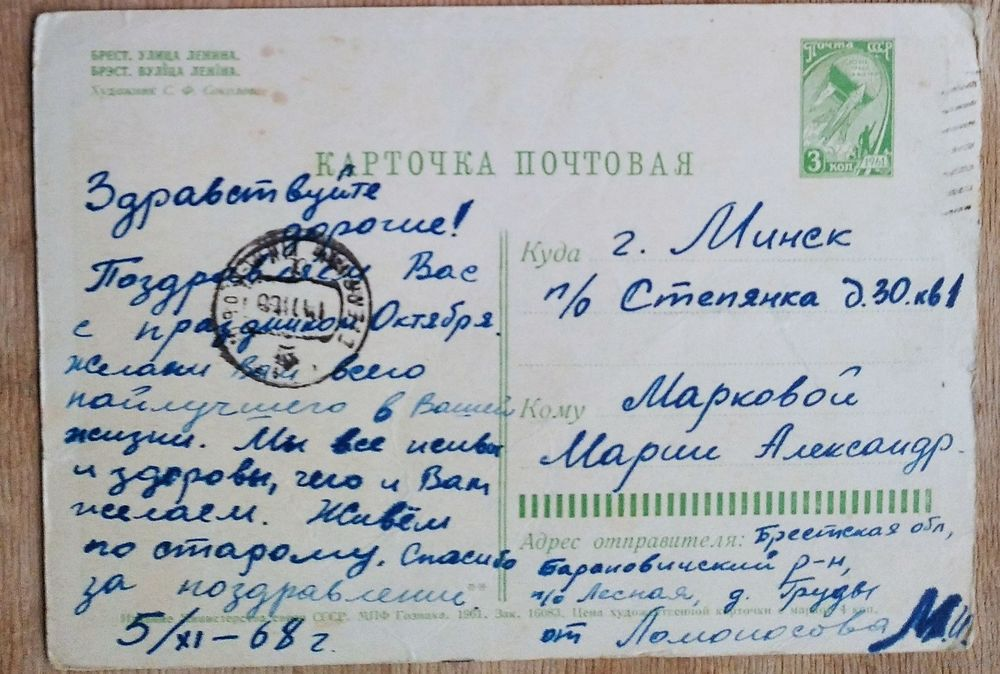

In [125]:
Image.open('example-orig.jpg')

Результат обрезки

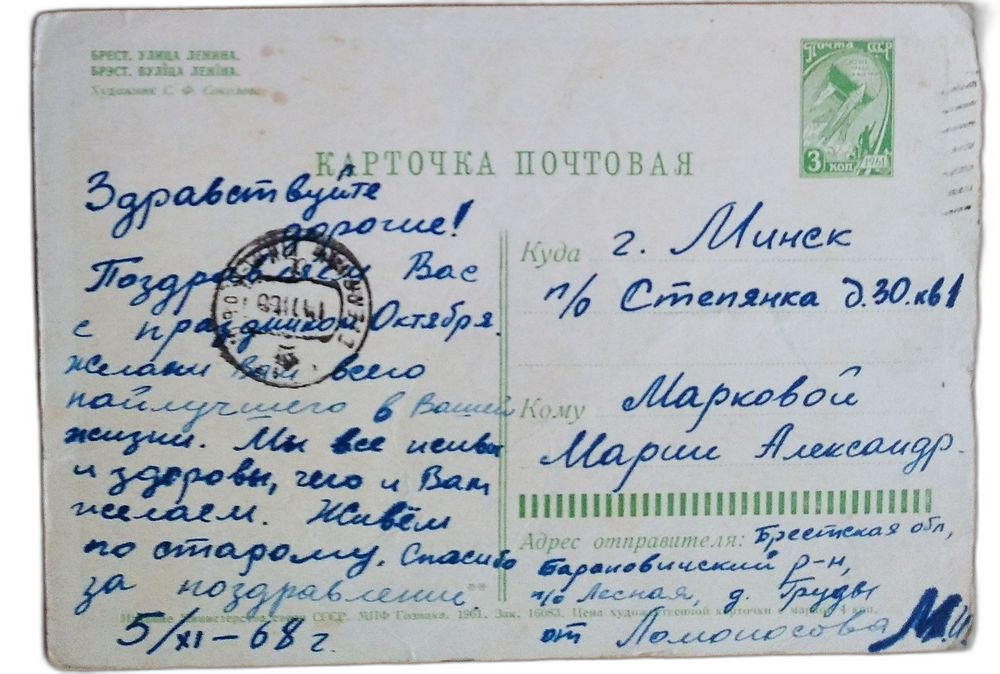

In [126]:
Image.open('example-rembg.jpg')

# Обрезка OpenCV
Обрезка с помощью сканнера документов на основе библиотеки OpenCV  
Исходный код сканнера: https://learnopencv.com/automatic-document-scanner-using-opencv/

In [4]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

## Пример
Скачиваем исходное изображение

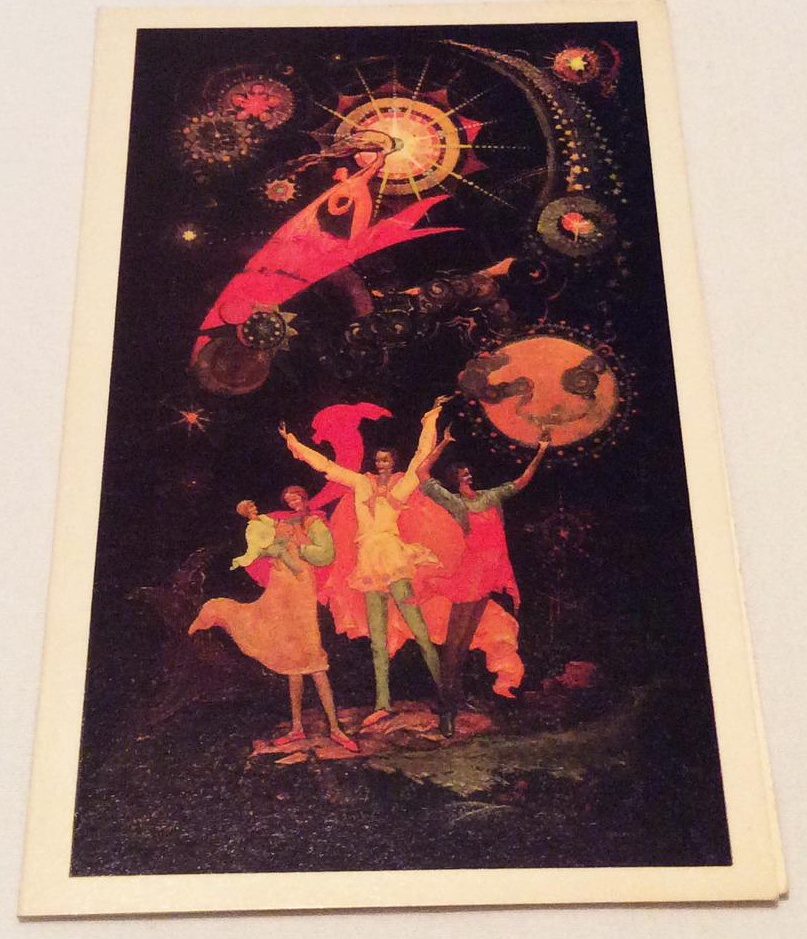

In [7]:
download('https://storage.yandexcloud.net/postcards-cropped/67_1.jpg', 'example-orig.jpg')
img = cv2.imread('example-orig.jpg')
cv2_imshow(img)  # здесь и далее: строка для вывода изображения в google colab. В jupyter notebook не работает

Процесс обработки сканнером

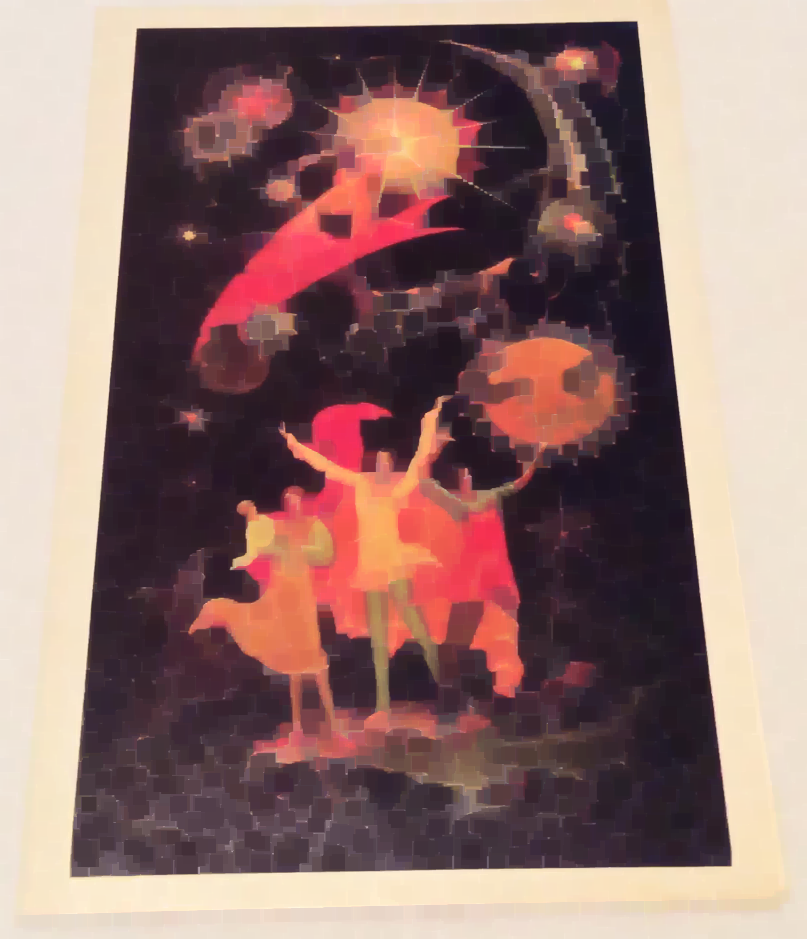

In [21]:
kernel = np.ones((5,5),np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
cv2_imshow(img)

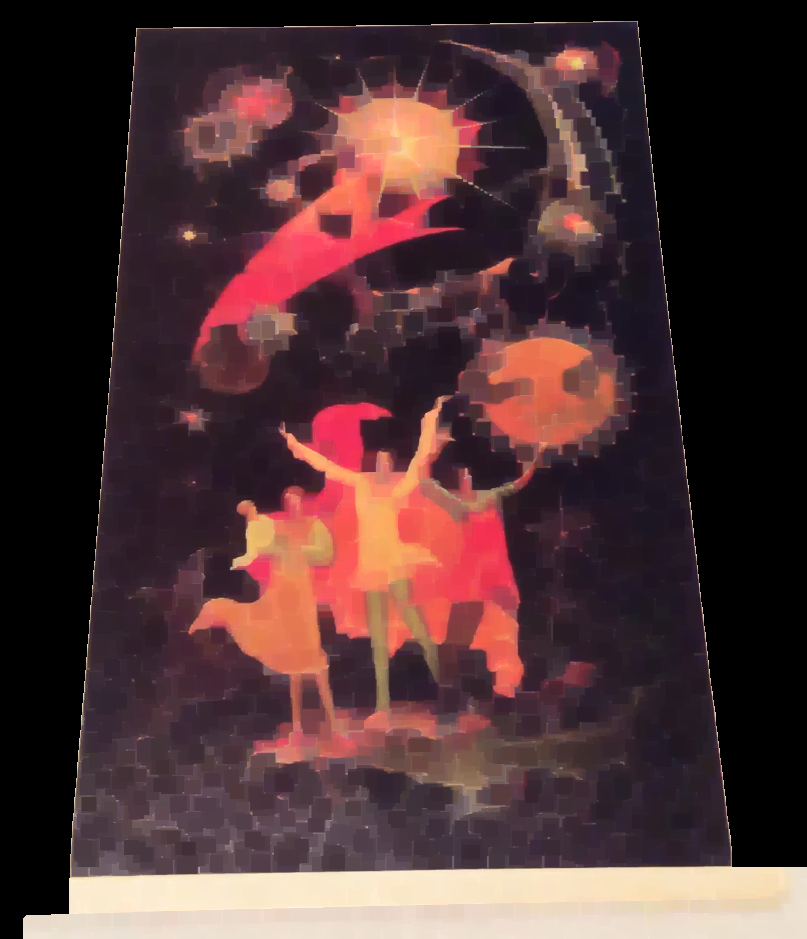

In [22]:
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (20,20,img.shape[1]-20,img.shape[0]-20)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
cv2_imshow(img)

In [23]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (11, 11), 0)
# Edge Detection.
canny = cv2.Canny(gray, 0, 200)
canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

In [24]:
# Blank canvas.
con = np.zeros_like(img)
# Finding contours for the detected edges.
contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Keeping only the largest detected contour.
page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)

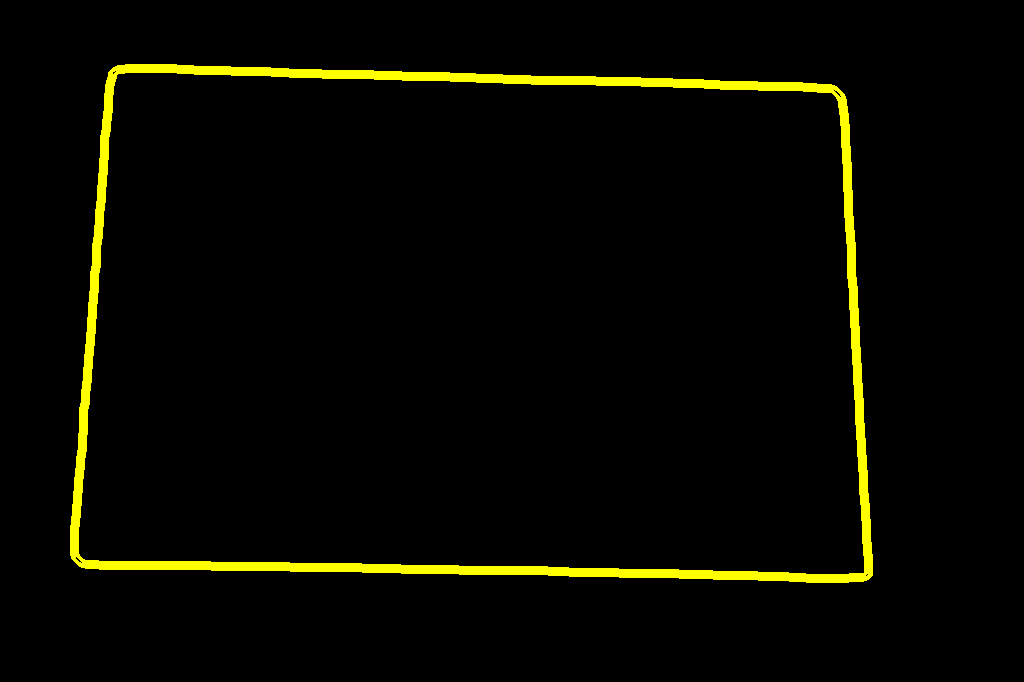

In [7]:
cv2_imshow(con)

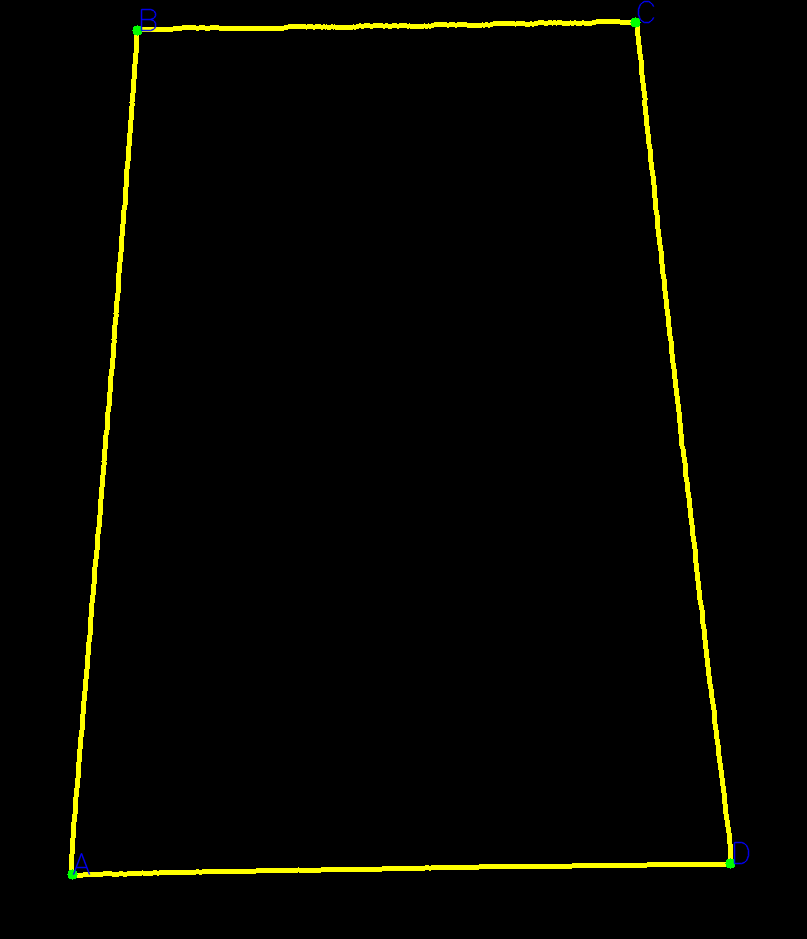

In [36]:
# Blank canvas.
con = np.zeros_like(img)
# Loop over the contours.
for c in page:
  # Approximate the contour.
  epsilon = 0.02 * cv2.arcLength(c, True)
  corners = cv2.approxPolyDP(c, epsilon, True)
  # If our approximated contour has four points
  if len(corners) == 4:
      break
cv2.drawContours(con, c, -1, (0, 255, 255), 3)
cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
# Sorting the corners and converting them to desired shape.
corners = sorted(np.concatenate(corners).tolist())
 
# Displaying the corners.
for index, c in enumerate(corners):
  character = chr(65 + index)
  cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)
cv2_imshow(con)

In [37]:
corners

[[72, 874], [137, 30], [635, 22], [730, 863]]

In [9]:
def order_points(pts):
    '''Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]
 
    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()

In [38]:
corners = order_points(corners)
corners

[[137, 30], [635, 22], [730, 863], [72, 874]]

In [39]:
(tl, tr, br, bl) = corners

# добавляем зазор, чтобы случайно не обрезать край открытки
gap_size = 20
tl[0] -= gap_size
tl[1] -= gap_size
tr[0] += gap_size
tr[1] -= gap_size
br[0] += gap_size
br[1] += gap_size
bl[0] -= gap_size
bl[1] += gap_size

corners = (tl, tr, br, bl)

# Finding the maximum width.
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))
# Finding the maximum height.
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))
# Final destination co-ordinates.
destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

In [40]:
destination_corners

[[0, 0], [698, 0], [698, 886], [0, 886]]

Вывод финального результата

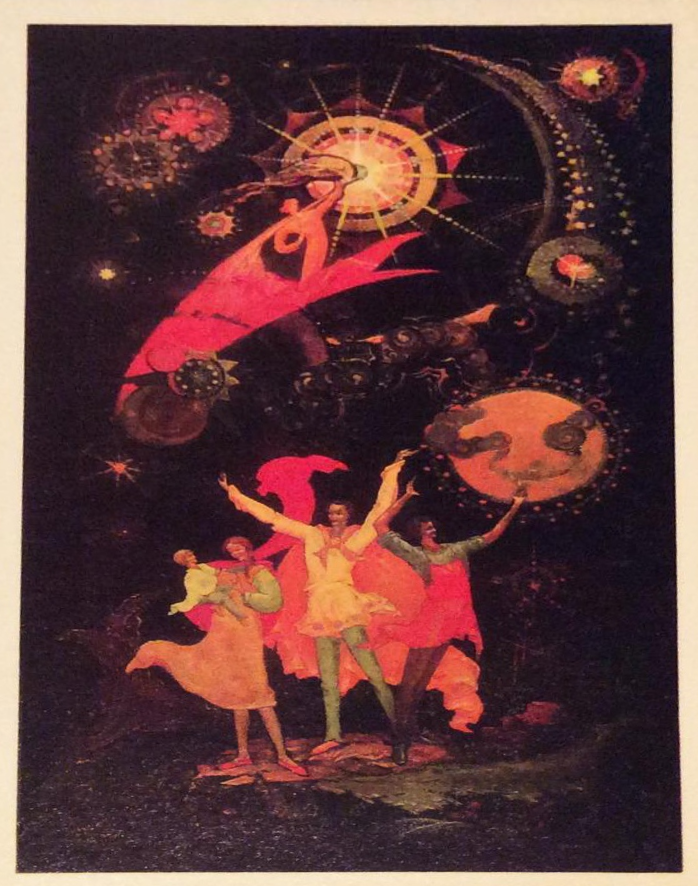

In [41]:
# Getting the homography.
M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
# Perspective transform using homography.
orig_img = cv2.imread('/content/477-1.jpg')
final = cv2.warpPerspective(orig_img, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LINEAR)
cv2_imshow(final)

## Функции

Функции на основе кода из статьи (тот же код, что в примере выше)

In [42]:
def blur_content(img):
  kernel = np.ones((5,5),np.uint8)
  img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
  return img

In [43]:
def grab_cut(img):
  mask = np.zeros(img.shape[:2],np.uint8)
  bgdModel = np.zeros((1,65),np.float64)
  fgdModel = np.zeros((1,65),np.float64)
  rect = (20,20,img.shape[1]-20,img.shape[0]-20)
  cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
  mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
  img = img*mask2[:,:,np.newaxis]
  return img

In [44]:
def detect_edge_contour_corners(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (11, 11), 0)
  # Edge Detection.
  canny = cv2.Canny(gray, 0, 200)
  canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

  # Blank canvas.
  con = np.zeros_like(img)
  # Finding contours for the detected edges.
  contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
  # Keeping only the largest detected contour.
  page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
  con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)

  # Blank canvas.
  con = np.zeros_like(img)
  # Loop over the contours.
  for c in page:
    # Approximate the contour.
    epsilon = 0.02 * cv2.arcLength(c, True)
    corners = cv2.approxPolyDP(c, epsilon, True)
    # If our approximated contour has four points
    if len(corners) == 4:
        break
  cv2.drawContours(con, c, -1, (0, 255, 255), 3)
  cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
  # Sorting the corners and converting them to desired shape.
  corners = sorted(np.concatenate(corners).tolist())
  return corners

In [45]:
def order_points(pts):
    '''Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]
 
    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()

In [47]:
def get_destination_corners(corners):
  (tl, tr, br, bl) = corners
  # Finding the maximum width.
  widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
  widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
  maxWidth = max(int(widthA), int(widthB))
  # Finding the maximum height.
  heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
  heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
  maxHeight = max(int(heightA), int(heightB))
  # Final destination co-ordinates.
  destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]
  return destination_corners

In [48]:
def final_transform(orig_img, corners, destination_corners):
  # Getting the homography.
  M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
  # Perspective transform using homography.
  final = cv2.warpPerspective(orig_img, M, (destination_corners[2][0], destination_corners[2][1]), 
                              flags=cv2.INTER_LINEAR)
  return final

Функция, чтобы оставить небольшие поля и случайно не обрезать часть открытки:

In [46]:
def add_gap(corners, gap_size=20):
  (tl, tr, br, bl) = corners
  tl[0] -= gap_size
  tl[1] -= gap_size
  tr[0] += gap_size
  tr[1] -= gap_size
  br[0] += gap_size
  br[1] += gap_size
  bl[0] -= gap_size
  bl[1] += gap_size
  corners = (tl, tr, br, bl)
  return corners

Функции оценки результатов обрезки: проверка на самые частые невалидные результаты
* `is_very_small` - проверка, что результат реалистичного размера (см. подробнее ниже)
* `is_one_color` - проверка, что результат не весь одного цвета

In [50]:
def is_very_small(orig_img, final):
  height_threshold = 560
  width_threshold = 380
  if orig_img.shape[0] - final.shape[0] > height_threshold or \
    orig_img.shape[1] - final.shape[1] > width_threshold:
    return True
  return False

In [51]:
def is_one_color(img):
  B_values = img[:, :, 0]
  G_values = img[:, :, 1]
  R_values = img[:, :, 2]
  if np.all(B_values == B_values[0]) and \
    np.all(G_values == G_values[0]) and \
    np.all(R_values == R_values[0]):
    return True
  return False

Основная функция: обработка одного изображения
* принимает путь к исходному файлу и путь, куда нужно записать результат
* возвращает True, если обработано успешно, и False, если проверка указывает на ошибку

In [49]:
def crop_opencv(input_filename, output_filename):
  orig_img = cv2.imread(input_filename)
  img = blur_content(orig_img)
  img = grab_cut(img)
  corners = detect_edge_contour_corners(img)
  corners = order_points(corners)
  corners = add_gap(corners)
  destination_corners = get_destination_corners(corners)
  final = final_transform(orig_img, corners, destination_corners)
  cv2.imwrite(output_filename, final)

  if not is_very_small(orig_img, final) and not is_one_color(final):
    return True  # success
  return False  # fail

Пример запуска

In [52]:
crop_opencv('example-orig.jpg', 'example-opencv.jpg')

True

## Проверка размера: поиск пороговых значений

In [58]:
crop_dict = dict()

for ind, row in tqdm(df.iterrows(), total=df.shape[0]):
    postcard_id = row['ID']
    filename_1 = 'pictures/' + str(postcard_id) + '-1.jpg'
    filename_2 = 'pictures/' + str(postcard_id) + '-2.jpg'
    filename_1_cut = 'pictures/' + str(postcard_id) + '-1-cut.jpg'
    filename_2_cut = 'pictures/' + str(postcard_id) + '-2-cut.jpg'

    img_1 = cv2.imread(filename_1)
    img_1_cut = cv2.imread(filename_1_cut)
    img_2 = cv2.imread(filename_2)
    img_2_cut = cv2.imread(filename_2_cut)

    crop_dict[postcard_id] = (
          img_1.shape[0] - img_1_cut.shape[0],  # 1 height diff
          img_1.shape[1] - img_1_cut.shape[1],  # 1 width diff
          img_2.shape[0] - img_2_cut.shape[0],  # 2 height diff
          img_2.shape[1] - img_2_cut.shape[1],  # 2 width diff
    )

100%|██████████| 125/125 [00:14<00:00,  8.65it/s]


In [62]:
crop_diff_df = pd.DataFrame.from_dict(crop_dict, orient='index', 
                                      columns=['1 height diff', '1 width diff', 
                                               '2 height diff', '2 width diff'])
crop_diff_df.head()

1 height diff  1 width diff  2 height diff  2 width diff
2180             93           154            157            87
2303            638          1005             68            63
2480            251           271            221           285
2484            137           308            654           962
2485            700           496            697           494

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

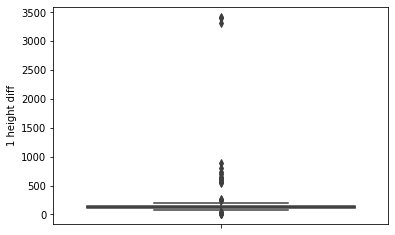

In [65]:
sns.boxplot(y=crop_diff_df['1 height diff']);

In [77]:
crop_diff_df['1 height diff'].quantile(0.9)

562.8000000000001

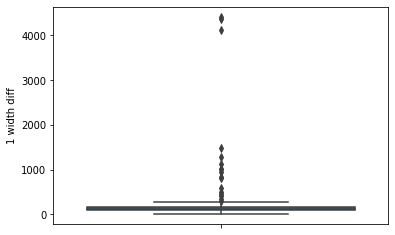

In [66]:
sns.boxplot(y=crop_diff_df['1 width diff']);

In [78]:
crop_diff_df['1 width diff'].quantile(0.9)

478.0000000000004

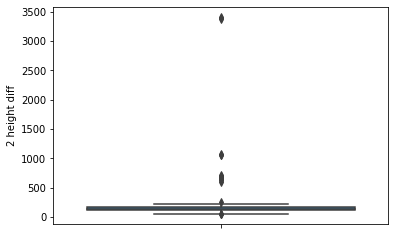

In [67]:
sns.boxplot(y=crop_diff_df['2 height diff']);

In [80]:
crop_diff_df['2 height diff'].quantile(0.9)

614.0000000000002

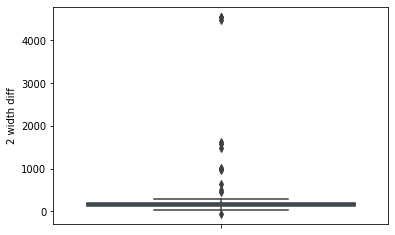

In [68]:
sns.boxplot(y=crop_diff_df['2 width diff']);

In [81]:
crop_diff_df['2 width diff'].quantile(0.9)

383.4000000000014